# Analysis of Financial Time Series(AFTS)


**Time series modeling is fundamentally different from traditional classification or regression tasks.** The key distinction lies in the **temporal structure**, which imposes an inherent **order** on the data. This ordering means the usual assumption—consistent statistical properties across observations—must be carefully reconsidered.

In time series analysis, we call the requirement that summary statistics remain stable **stationarity**. This ensures that metrics like mean, variance, and autocovariance do not drift over time.

However, real-world time series are frequently non-stationary due to influences such as **trends**, **seasonality**, or other time-dependent patterns.

When applying a model that assumes stationarity, you're effectively treating your data as a realization of a **stationary stochastic process**. Therefore, it’s essential to begin any analysis by checking for signs of **trend or seasonality**—and, if present, to remove or account for them before proceeding.


- https://github.com/mchoimis/AFTS
- https://github.com/ragdoll99/time_series_risk_mgmt
- https://github.com/2wavetech/How-to-Check-if-Time-Series-Data-is-Stationary-with-Python

## Import Libraries

In [88]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.linalg import norm
from scipy.stats import entropy

np.random.seed(42)

## Load Data

In [139]:
# file_path = "./mt5/DXYm_H4_202001020000_202508012000.csv"
file_path = "./mt5/DXYm_M15_202008020000_202508012045.csv.parquet"
# file_path = "./ccxt/binanceusdm/btc_usdt_4h.csv"

if ".parquet" in file_path:
    ohlcv = pd.read_parquet(file_path)
else:
    ohlcv = pd.read_csv(file_path)
    
if "Unnamed: 0" in ohlcv.columns:
    ohlcv.drop(columns=["Unnamed: 0"], inplace=True)
    
if "tick_volume" in ohlcv.columns:
    ohlcv.drop(columns=["volume", "spread"], inplace=True)
    ohlcv.rename(columns={"tick_volume": "volume"}, inplace=True)
    
if "timestamp" not in ohlcv.columns:
    ohlcv["date"] = pd.to_datetime(ohlcv["date"] + " " + ohlcv["time"])
    ohlcv.rename(columns={"date": "timestamp"}, inplace=True)
    ohlcv.drop(columns=["time"], inplace=True)

ohlcv

,timestamp,open,high,low,close,volume
0,2020-08-02 00:00:00,93.426,93.435,93.273,93.397,6872
1,2020-08-03 00:00:00,93.397,93.979,93.344,93.526,110054
2,2020-08-04 00:00:00,93.526,93.824,93.128,93.134,98010
3,2020-08-05 00:00:00,93.133,93.233,92.543,92.760,99985
4,2020-08-06 00:00:00,92.759,93.079,92.471,92.795,124268
...,...,...,...,...,...,...
101030,2025-08-01 19:45:00,98.719,98.806,98.697,98.801,1436
101031,2025-08-01 20:00:00,98.800,98.801,98.701,98.719,692
101032,2025-08-01 20:15:00,98.719,98.721,98.643,98.646,409
101033,2025-08-01 20:30:00,98.647,98.689,98.590,98.676,722


In [140]:
# Prices
ohlcv["hl2"] = (ohlcv["high"] + ohlcv["low"]) / 2.0 # hlc2 Prices 
ohlcv["hlc3"] = (ohlcv["high"] + ohlcv["low"] + ohlcv["close"]) / 3.0 # hlc3 prices
ohlcv["ohlc4"] = (ohlcv["open"] + ohlcv["high"] + ohlcv["low"] + ohlcv["close"]) / 4.0 # ohlc4 prices

# First difference of price (ΔP_t = P_t – P_{t–1})
ohlcv["price_diff"] = ohlcv["hlc3"].diff()

# Simple return (R_t = (P_t – P_{t–1}) / P_{t–1})
ohlcv["simple_ret"] = ohlcv["hlc3"].pct_change()

# Log return (r_t = ln(P_t / P_{t–1}))
ohlcv["log_ret"] = np.log(ohlcv["hlc3"] / ohlcv["hlc3"].shift(1))

ohlcv

,timestamp,open,high,low,close,volume,hl2,hlc3,ohlc4,price_diff,simple_ret,log_ret
0,2020-08-02 00:00:00,93.426,93.435,93.273,93.397,6872,93.3540,93.368333,93.38275,NaN,NaN,NaN
1,2020-08-03 00:00:00,93.397,93.979,93.344,93.526,110054,93.6615,93.616333,93.56150,0.248000,0.002656,0.002653
2,2020-08-04 00:00:00,93.526,93.824,93.128,93.134,98010,93.4760,93.362000,93.40300,-0.254333,-0.002717,-0.002720
3,2020-08-05 00:00:00,93.133,93.233,92.543,92.760,99985,92.8880,92.845333,92.91725,-0.516667,-0.005534,-0.005549
4,2020-08-06 00:00:00,92.759,93.079,92.471,92.795,124268,92.7750,92.781667,92.77600,-0.063667,-0.000686,-0.000686
...,...,...,...,...,...,...,...,...,...,...,...,...
101030,2025-08-01 19:45:00,98.719,98.806,98.697,98.801,1436,98.7515,98.768000,98.75575,-0.039333,-0.000398,-0.000398
101031,2025-08-01 20:00:00,98.800,98.801,98.701,98.719,692,98.7510,98.740333,98.75525,-0.027667,-0.000280,-0.000280
101032,2025-08-01 20:15:00,98.719,98.721,98.643,98.646,409,98.6820,98.670000,98.68225,-0.070333,-0.000712,-0.000713
101033,2025-08-01 20:30:00,98.647,98.689,98.590,98.676,722,98.6395,98.651667,98.65050,-0.018333,-0.000186,-0.000186


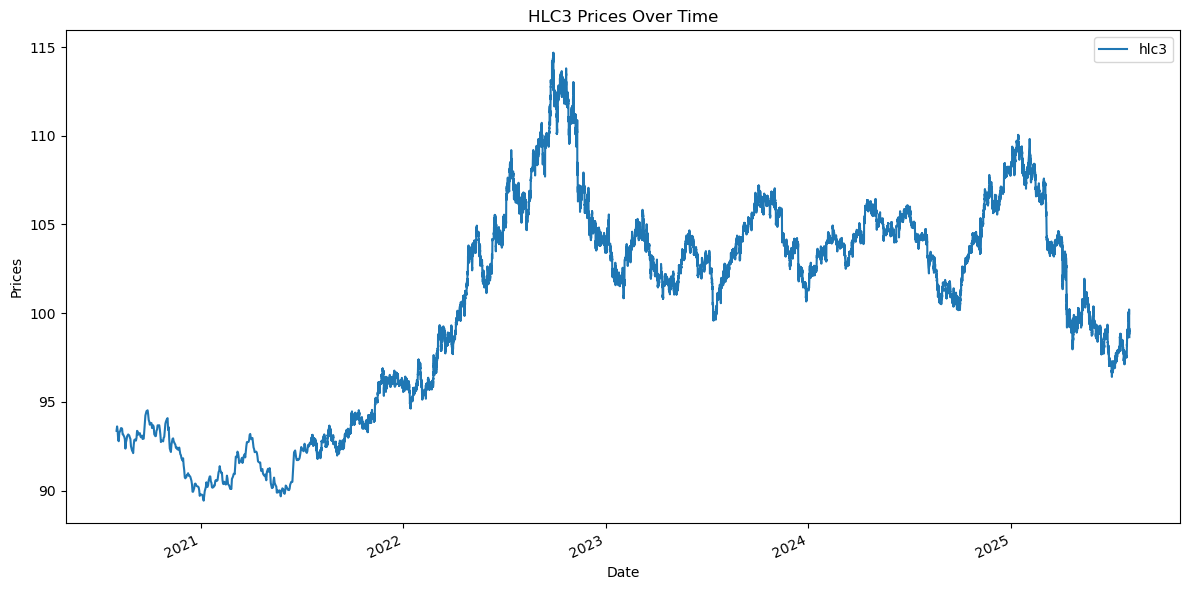

In [141]:
ohlcv.plot(x='timestamp', y='hlc3', figsize=(12, 6), title='HLC3 Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

## Extract price series

In [169]:
# Extract price series
dates = ohlcv["timestamp"].values
highs = ohlcv["high"].values
lows = ohlcv["low"].values
closes = ohlcv["close"].values
volumes = ohlcv["volume"].values

hl2 = ohlcv["hl2"].values
hlc3 = ohlcv["hlc3"].values
ohlc4 = ohlcv["ohlc4"].values

price_diff = ohlcv["price_diff"].dropna().values
simple_ret = ohlcv["simple_ret"].values
log_ret = ohlcv["log_ret"].values

## Randomness Check 

Check for randomness in time series using auto-correlation plot.


Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

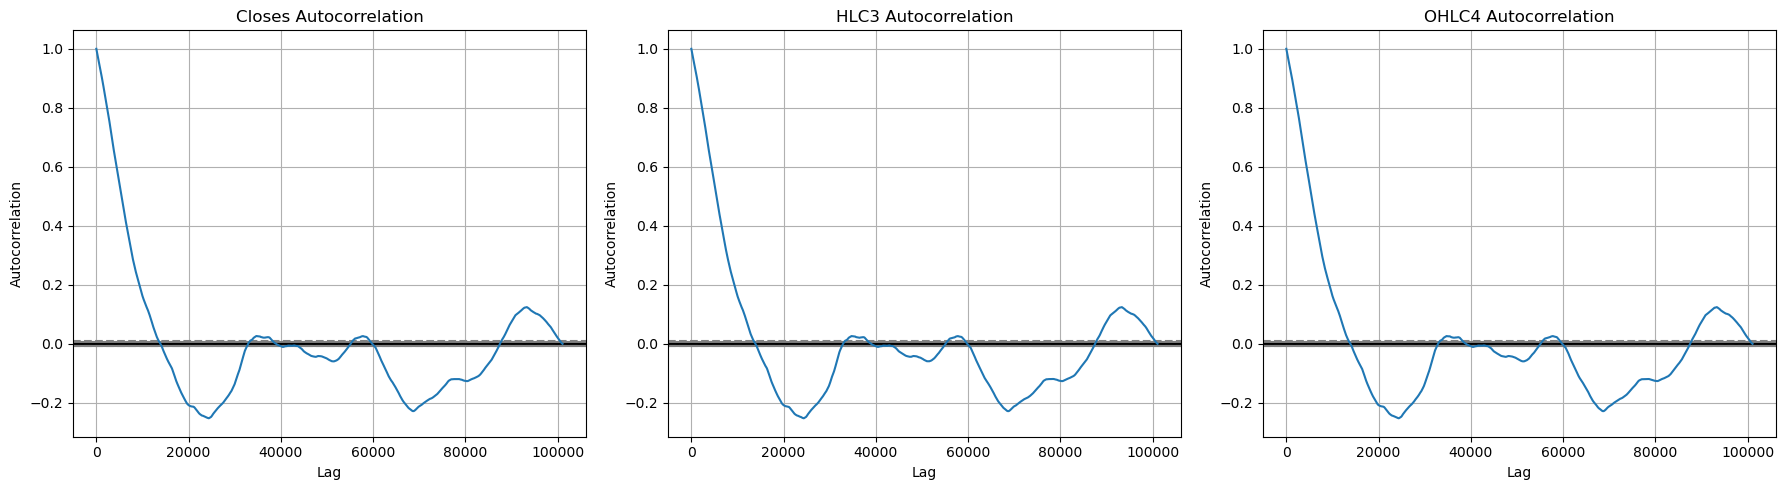

In [143]:
from pandas.plotting import autocorrelation_plot

f3, (ax7, ax8, ax9) = plt.subplots(1, 3, figsize=(18, 5))

autocorrelation_plot(closes, ax=ax7)
ax7.set_title('Closes Autocorrelation')

autocorrelation_plot(hlc3, ax=ax8)
ax8.set_title('HLC3 Autocorrelation')

autocorrelation_plot(ohlc4, ax=ax9)
ax9.set_title('OHLC4 Autocorrelation')

plt.tight_layout()
plt.show()

## Returns


Around returns...

N can be hourly, daily, weekly, etc

In time series analysis, log-returns are preferred over simple returns due to their time-additive property. 

This means that the sum of daily log-returns over a given period (such as a month) equals the log-return for the entire period. Thanks to this additive nature, log-returns are commonly used by finance professionals for risk management. Log-return is computed as the natural logarithm of the ratio between the ending value and the beginning value.

### Simple

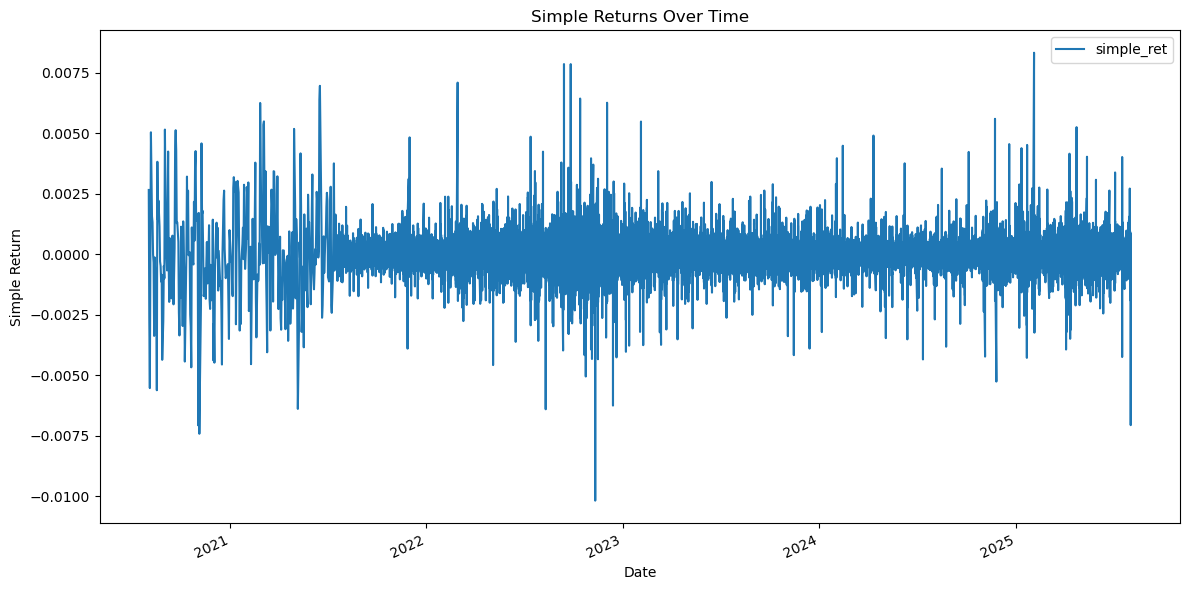

In [144]:
# Calculate N simple returns
# simpleret = np.diff(hlc3)[1:]
# simpleret

ohlcv.plot(x='timestamp', y='simple_ret', figsize=(12, 6), title='Simple Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Simple Return')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

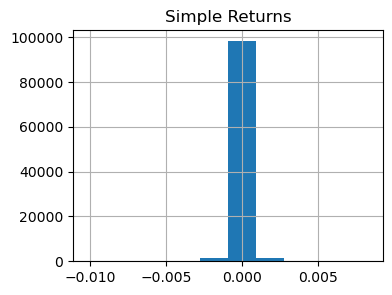

In [145]:
# Plot histogram
ohlcv["simple_ret"].hist(figsize=(4, 3))
plt.title('Simple Returns')
plt.show()

### Logarithmic 

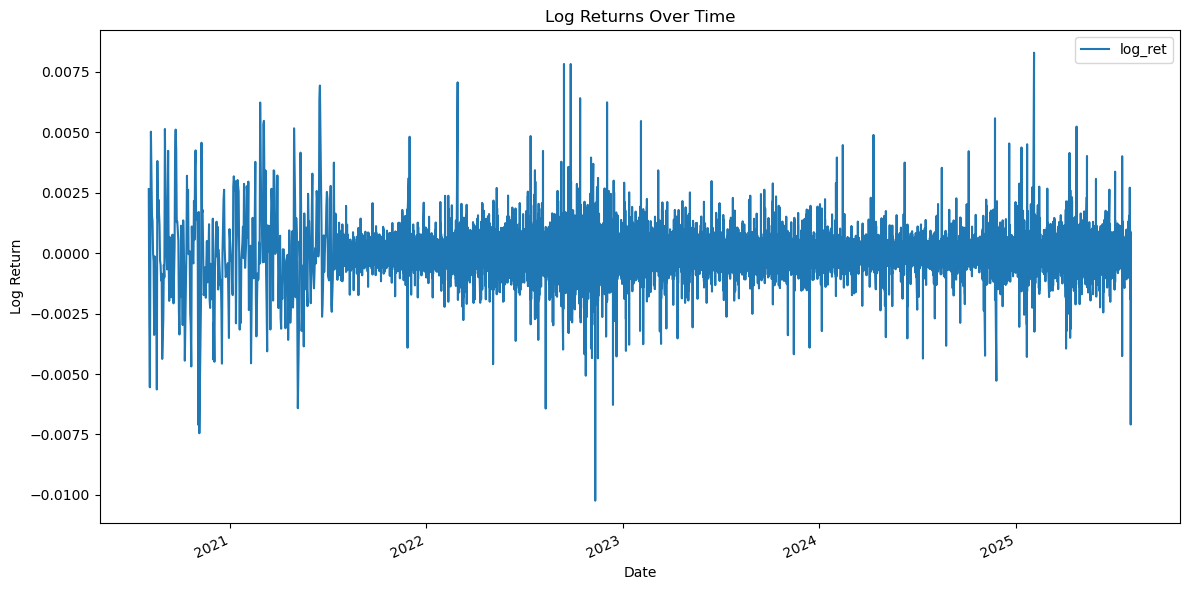

In [157]:
# # Calculate N log returns
# logret = np.diff(np.log(hlc3))[1:]
# logret

ohlcv.plot(x='timestamp', y='log_ret', figsize=(12, 6), title='Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

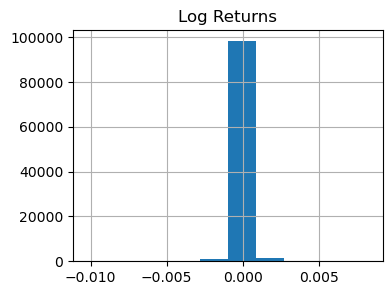

In [158]:
# Plot histogram
ohlcv["log_ret"].hist(figsize=(4, 3))
plt.title('Log Returns')
plt.show()

### Skewness, Kurtosis and Jarque-Bera Test

#### Skewness test

The coefficient of skewness is 0 (sysmetric), -ve(left-skewed), +ve(right-skewed)


In [159]:
# sp.skew(simple_ret)
ohlcv["simple_ret"].skew()

0.021069380475034673

In [160]:
# skewness = sp.skew(log_ret)
skewness = ohlcv["log_ret"].skew()
skewness

-0.0037272401378420825

#### Kurtosis

Test heavy-tail or thin-tail, 3 (normal), <3 (thin-tailed), >3 (heavy-tailed)

In [161]:
# sp.kurtosis(simple_ret)
ohlcv["simple_ret"].kurtosis()

39.84748168076598

In [162]:
# kurtosis = sp.kurtosis(log_ret)
kurtosis = ohlcv["log_ret"].kurtosis()
kurtosis

39.86887634469522

#### Jarque-Bera test

Test for normality 

In [163]:
jqb_simpleret = sm.stats.jarque_bera(simple_ret[1:])
jqb_simpleret

(6683658.792475812, 0.0, 0.021069067667454578, 42.84545033895768)

In [164]:
jqb_logret = sm.stats.jarque_bera(log_ret[1:])
jqb_logret

(6690830.57854592, 0.0, -0.0037271848011904245, 42.86684394411625)

### Stationarity Toolkit

Apply transformations such as:

* **First-order differencing**: $\Delta y_t = y_t - y_{t-1}$ 


First-order differencing => price_diff 


In [165]:
from toolkit import StationarityToolkit

toolkit = StationarityToolkit(alpha=0.05)


In [170]:
toolkit.perform_pp_test(price_diff)     # Phillips-Perron test for variance non-stationarity

0.0

In [171]:
toolkit.adf_test(price_diff)            # Augmented Dickey-Fuller test for trend

Test Statistic                    -42.497270
p-value                             0.000000
#Lags Used                         60.000000
Number of Observations Used    100973.000000
Critical Value (1%)                -3.430415
Critical Value (5%)                -2.861569
Critical Value (10%)               -2.566785
dtype: float64

In [172]:
toolkit.kpss_test(price_diff)           # KPSS test for trend

c:\Users\hp\Desktop\Samuel\nautilus_ai\data\toolkit\stationarity.py:269: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c")


Test Statistic            0.236069
p-value                   0.100000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [ ]:
stop

## Entropy-based Tests


**Entropy Features:**

**Shannon entropy:** This measures the degree of randomness or uncertainty in a probability distribution. In finance, Shannon entropy can be used to measure the uncertainty of price changes, trading volumes, or other market variables. To calculate Shannon entropy, you first need to calculate the probability distribution of the variable of interest. This can be done using techniques such as kernel density estimation or histogramming. Once you have the probability distribution, you can calculate Shannon entropy using the formula: H = - sum(p * log(p)), where p is the probability of each value in the distribution.


**Approximate entropy:** This is a measure of the complexity of a time series. It can be used to identify patterns or anomalies in financial market data. To calculate approximate entropy, you first need to define a tolerance level and a length of comparison. The tolerance level determines how similar two data points need to be in order to be considered "close". The length of comparison determines how many data points are compared. Once you have defined these parameters, you can calculate approximate entropy using the formula: ApEn(m, r, N) = (phi(m+1) - phi(m)), where m is the length of comparison, r is the tolerance level, N is the length of the time series, and phi() is a function that calculates the average logarithm of the number of sequences in the time series that are similar to each other.


---

#### 🔍 What Entropy Tells You

| Metric                         | Interpretation                                                        | When to Trade It                                                                                               |
| ------------------------------ | --------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Shannon Entropy**            | Measures the *uncertainty* or *information richness* in a time series | Higher entropy = more random (good for statistical arbitrage); lower = more structured (good for trend models) |
| **Approximate Entropy (ApEn)** | Measures the *regularity* and *pattern predictability*                | Lower ApEn = predictable (good for forecasting); higher = chaotic (avoid unless using volatility harvesting)   |

So:

* Low Shannon entropy + low ApEn → highly structured asset → potential edge
* High Shannon entropy + low ApEn → informationally rich but still structured → alpha opportunities
* High Shannon entropy + high ApEn → nearly random → likely *no persistent edge*

---

#### 🧠 Choosing Strategy Types by Entropy Profile

| Entropy Regime              | Suggested Strategy                              |
| --------------------------- | ----------------------------------------------- |
| **Low Shannon, Low ApEn**   | Trend-following, breakout, pattern recognition  |
| **High Shannon, Low ApEn**  | Volatility-based trading, statistical arbitrage |
| **Low Shannon, High ApEn**  | Range-bound, liquidity mining                   |
| **High Shannon, High ApEn** | Avoid or use ensemble/machine-learning filters  |

---

#### 📈 Why It Might Work

1. **Entropy adapts to regime** — it’s not just volatility. You capture structural change, information flow, and the persistence of memory in price behavior.
2. **Avoids overfitting** — instead of predicting returns directly, you assess *structure* and *suitability*.
3. **Asset selection becomes adaptive** — as markets become more/less chaotic (e.g., BTC after halving vs equities post-FOMC), your chosen assets shift.

---

#### 🧠 Example Application (BTC vs ETH vs SPY vs EUR/USD)

| Asset    | Shannon Entropy | Approx. Entropy | Trade Decision                           |
| -------- | --------------- | --------------- | ---------------------------------------- |
| BTC/USDT | 3.95            | 8.8e-08         | Very structured → ✅ Trend / modelable    |
| ETH/USD  | 4.1             | 2.1e-07         | Structured w/ noise → ⚠️ Trend w filters |
| SPY      | 3.2             | 1.9e-06         | Some predictability → ✅ Momentum         |
| EUR/USD  | 4.7             | 1.1e-05         | Highly random → 🚫 Avoid unless hedging  |


---

#### 🧠 Interpretation Logic

| Entropy Regime           | Hurst                    | Suggested Use                   |
| ------------------------ | ------------------------ | ------------------------------- |
| Low Entropy, H > 0.6     | Persistent trends        | ✅ Trend-following               |
| Low Entropy, H < 0.4     | Mean-reverting structure | ✅ Stat arb / MR                 |
| High Entropy, Any H      | Structureless            | ❌ Avoid or use ML ensemble      |
| Medium Entropy, H \~ 0.5 | Random walk              | ⚠️ Trade cautiously, hedge only |


#### 🔬 Strategy-Aware Asset Filtering

For each candidate, define:

```text
IF Structure Score > 0.75:
    Use Trend Model (momentum, breakout)
ELSE IF Score between 0.4 and 0.75:
    Use Range-Based Model (MR, reversal, bands)
ELSE:
    Ignore or hedge only
```

#### Sources
- https://github.com/sumilk/algo_trading

### Shannon entropy

In [ ]:
def shannon_entropy(returns, bins=50):
    hist, _ = np.histogram(returns, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=np.e)

# Calculate the probability distribution of price changes
price_changes = np.diff(hlc3) / hlc3[:-1]
# p, bins = np.histogram(price_changes, bins='auto', density=True)

# Calculate Shannon entropy
# shannon_entropy = entropy(p)
sentropy = shannon_entropy(price_changes, bins='auto')
print("Shannon entropy:", sentropy)

Shannon entropy: 3.641799368102739


### Approximate entropy

In this code snippet, the 'apen' function is defined manually using NumPy and a for loop. The 'apen' function takes three arguments: the financial time series data, the embedding dimension (i.e., the number of data points used to define a state), and the tolerance value (i.e., the maximum distance between two similar states).

In this implementation of the 'apen' function, the data vectors are reshaped to be 2-dimensional arrays with a single column, and then the distance matrix is calculated using the absolute difference between the data vectors. The 'np.max' function is then used to find the maximum distance between each pair of data vectors along the 0th axis (i.e., the rows), and the resulting array is compared to the tolerance value to determine the number of similar patterns

In [ ]:
# Define the ApEn function
from scipy.spatial.distance import cdist

def approximate_entropy(U, m=2, r=None):
    """
    Calculate the Approximate Entropy (ApEn) of a time series faster.

    Args:
        U: The time series data (numpy array or list).
        m: The embedding dimension.
        r: The tolerance value. If None, it is set to 0.2 * std(U).

    Returns:
        The Approximate Entropy value, or np.nan if calculation is not possible.
    """
    U = np.asarray(U, dtype=float)
    U = U[~np.isnan(U)]  # Drop NaNs if any

    N = len(U)
    if N < m + 1:
        return np.nan  # Not enough data points

    if r is None:
        r = 0.2 * np.std(U)
    if r == 0:  # Avoid division by zero if std is 0
        return 0.0

    def _phi(m):
        # Create embedded vectors
        X = np.array([U[i : i + m] for i in range(N - m + 1)])

        # Calculate the maximum distance between all pairs of vectors
        # Using cdist with 'chebyshev' metric is equivalent to np.max(np.abs(X[:, None] - X[None, :]), axis=2)
        distances = cdist(X, X, metric='chebyshev')

        # Count the number of distances less than or equal to r
        count = np.sum(distances <= r)

        return count / ((N - m + 1)**2)

    phi_m = _phi(m)

    # Ensure there are enough data points for m+1 comparison
    if N - m < 1:
         return np.nan

    phi_m_plus_1 = _phi(m + 1)

    # Handle case where phi_m or phi_m_plus_1 is 0
    if phi_m == 0 or phi_m_plus_1 == 0:
        return np.nan

    return np.log(phi_m / phi_m_plus_1)

# def approximate_entropy(U, m=2, r=None):
#     # Ensure U is a numpy array of floats
#     U = np.asarray(U, dtype=float)
#     U = U[~np.isnan(U)] # Drop NaNs if any
#     if len(U) < m + 1:
#         return np.nan # Not enough data points

#     if r is None:
#         r = 0.2 * np.std(U)
#     if r == 0: # Avoid division by zero if std is 0
#         return 0.0
#     N = len(U)
#     def _phi(m):
#         X = np.array([U[i:i + m] for i in range(N - m + 1)])
#         count = 0
#         # Use broadcasting and sum for efficiency
#         diffs = np.max(np.abs(X[:, None] - X[None, :]), axis=2)
#         count = np.sum(diffs <= r)

#         return count / ((N - m + 1)**2) # Correction for count calculation

#     phi_m = _phi(m)
#     if N - m < 1:
#          return np.nan # Not enough data for m+1 comparison

#     phi_m_plus_1 = _phi(m + 1)

#     # Handle case where phi_m or phi_m_plus_1 is 0
#     if phi_m == 0 or phi_m_plus_1 == 0:
#         return np.nan # Or some other indicator of undefined/infinite entropy

#     return np.log(phi_m / phi_m_plus_1)


# def apen(x, m, r):
#     """
#     Calculate the Approximate Entropy (ApEn) of a time series.
#     x: the time series data
#     m: the embedding dimension
#     r: the tolerance value
#     """
#     N = len(x)
#     phi = np.zeros((N - m + 1, 1))
#     for i in range(N - m + 1):
#         # Define the data vectors
#         xmi = x[i:i+m].reshape(-1, 1)
#         xmj = x[i+1:i+m+1].reshape(-1, 1)
#         # Calculate the distance matrix
#         C = np.abs(xmj - xmi.T)
#         # Count the number of similar patterns
#         phi[i] = np.sum(np.max(C, axis=1) <= r) / (N - m + 1)
#     ApEn = np.mean(phi)
#     return ApEn

# Generate a random price series
# price_series = np.random.normal(100, 10, 1000)


In [ ]:
# Calculate the ApEn of the price series
from itertools import product

tolerances = [0.1, 0.2, 0.5, 0.7]
embedding_dimensions = [2, 3, 5, 7, 9, 12]

results = []
for tolerance, dimension in product(tolerances, embedding_dimensions):
    approx_entropy = approximate_entropy(hlc3, dimension, tolerance)
    results.append({"Tolerance": tolerance, "Embedding Dimension": dimension, "Approximate Entropy": approx_entropy})

# Convert the results to a pandas DataFrame
df_approx_entropy = pd.DataFrame(results)

# Display the DataFrame
print("\nApproximate Entropy Results:")
df_approx_entropy


Approximate Entropy Results:


,Tolerance,Embedding Dimension,Approximate Entropy
0,0.1,2,0.728251
1,0.1,3,0.678465
2,0.1,5,0.544146
3,0.1,7,0.307174
4,0.1,9,0.133392
5,0.1,12,0.024980
6,0.2,2,0.392402
7,0.2,3,0.377258
8,0.2,5,0.357542
9,0.2,7,0.317623


In [ ]:
highest_entropy_row = df_approx_entropy.loc[df_approx_entropy['Approximate Entropy'].idxmax()]
print("\nRow with the highest Approximate Entropy:")
highest_entropy_row


Row with the highest Approximate Entropy:


Tolerance              0.100000
Embedding Dimension    2.000000
Approximate Entropy    0.728251
Name: 0, dtype: float64

In [ ]:
lowest_entropy_row = df_approx_entropy.loc[df_approx_entropy['Approximate Entropy'].idxmin()]
print("\nRow with the lowest Approximate Entropy:")
lowest_entropy_row


Row with the lowest Approximate Entropy:


Tolerance               0.10000
Embedding Dimension    12.00000
Approximate Entropy     0.02498
Name: 5, dtype: float64

If the approximate entropy is calculated as 0, it means that the price series is highly predictable or regular. In other words, there is very little randomness or complexity in the data. This can happen if the data is generated by a simple model or if there is a high degree of autocorrelation in the data.

To confirm this, you can try a more complex or unpredictable price series and see if the approximate entropy value changes. You can also try adjusting the tolerance and length_of_comparison parameters to see if that affects the result.


**Design an index combining Shannon Entropy and ApEn:**

High Shannon + Low ApEn → Fractal Order zone

High Shannon + High ApEn → Chaotic Volatility

Low Shannon + Low ApEn → Stale or manipulated

Low Shannon + High ApEn → Noisy but narrow
